<h3>About me</h3>

My name is Dmitry Smirnov, currently I'm PhD student in Brain and Mind Laboratory, NBE department in Aalto University, Finland. I mostly do cognitive neuroscience with fMRI, using various classification and regression models. You can see more about me:

<a href=https://www.linkedin.com/in/dmismirnov>My LinkedIn</a>

<a href=http://becs.aalto.fi/~smirnod1/index.html>My personal page</a>

<h3>About project</h3>

I've been reading and playing around with Bayesian methods for quite a while now, and in one conversation I was asked if these methods can help solve a fairly simple research question that was answered with frequentist stats. I was eager to take the challenge, also to check how much do I really know about this methodology.

The data were obtained from previously published study of the influence of culture on the incidence of extreme judgment in moral dilemmas. Original study has showed, among other results, that in comparison with the English-speaking countries, Russian subjects avoided extreme judgments (<a href=http://www.researchgate.net/profile/Marc_Hauser/publication/255712292_Moral_Judgments_in_Russian_Culture_Universality_and_Cultural_Specificity/links/0046352058cfc7cf6b000000.pdf>Arutyunova et al., 2013</a>). I was provided with tables for Russian and American samples, and given permission to run some Bayesian analysis on these.

Reference: Arutyunova KR, Alexandrov YuI, Znakov VV, Hauser MD (2013) Moral Judgments in Russian Culture: Universality and Cultural Specificity. Journal of Cognition and Culture 13: 255–285.

<h2>Importing packages, loading data and preprocessing</h2>

In this notebook, we will use a hierarchical model. To give quick overview, in hierarchical model, we look at our data as structured in the most natural way - each dilemma is an instance of some common group process of decision making. So we will model each dilemma, but tie the parameters of dilemmawise models to some group parameters.

We start with simply adding packages that we are going to use later in the code, and load data for Russian and American samples. Technically, dataRU and dataENG are just matrixes of Participant by Dilemma shape.

I also setup matplotlib in a way that in throws plots into the notebook and setup up default nice grid for seaborn.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3
from sklearn.cross_validation import KFold
import scipy.stats as sp

In [11]:
%matplotlib inline
sns.set_style('darkgrid')

In [12]:
dataRU = np.array(pd.read_csv('http://www.becs.aalto.fi/~smirnod1/RusKarina.csv',header=None))
dataENG = np.array(pd.read_csv('http://www.becs.aalto.fi/~smirnod1/EngKarina.csv',header=None))

In [13]:
print(dataRU.shape)
print(dataENG.shape)

(327, 30)
(332, 30)


Now we transform our data, so that extreme answers (7 and 1) are coded as '1', and all other answers as '0'. Our final matrices will be data1, which contains encoded (1-extreme, 0-moderate) responses from 327 individuals over 30 moral dilemmas from Russian sample, and data2 contains encoded responses from 330 individuals over 30 moral dilemmas from American sample.

In [14]:
data1 = np.zeros(np.shape(dataRU))
data2 = np.zeros(np.shape(dataENG))
data1[dataRU == 7] = 1
data1[dataRU == 1] = 1
data2[dataENG == 7] = 1
data2[dataENG == 1] = 1

For some of the later analyses we will need a few parameters, so let's start with them.
First, for this model we need to know the number of stories used, so S is just auxiliary variable for that. 
Then, we also need to keep the indices for different stories, s_idx is for that.
We also need 's' and 'r' are parameters for Gamma distribution, but see more explanation below.

In [45]:
S = data1.shape[1]
s_idx = [i for i in range(S)]
s = 0.01
r = 0.01
nsamp = 100000 # How many samples to get from MCMC
njobs = 4 # how many jobs to run in parallel
s_idx = [i for i in range(S)]

<h2>Model specification</h2>

In Bayesian analysis, we need to have prior beliefs about the way our model is parametrized. Here I used approach taken by John Krushcke (Kruschke, 2014: http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/). 

<div style="font-size: 16px">
$$\kappa_g \sim \mathcal{Gamma}(\alpha=0.01,\beta=0.01)$$
$$\omega_g \sim \mathcal{Beta}(1,1)$$
$$\theta_{g,s} \sim \mathcal{Beta}(\omega_g(\kappa_g-2)+1), (1-\omega_g)(\kappa_g-2)+1)$$
$$y_{g,s} \sim \mathcal{Ber}(\theta_{g,s})$$
</div>

In this case, for each group I have a Bernoulli likelihood function with parameter $\theta_{g,s}$. $\theta_{g,s}$ comes from Beta distribution which is parametrized with mode $\omega$ and concentration $\kappa$ hyperparameters. $\kappa$ gets Gamma prior with shape = 0.01 and rate = 0.01, which is a vague prior. $\omega$ gets uniform Beta(1,1) prior.
So, to give another overview, now for each group we have group mode $\omega$ and group concentration $\kappa$, which are informing story-specific $\theta_{g,s}$, and are informed by story-specific $\theta_{g,s}$. In applied sense that means, that we will get shrinkage effect, so if $\theta_{g,s}$ will be far away from group $\omega$, it will be pulled towards group estimate.

For a little more intuitive explanation, we can think of our data as being two factories, each producing 30 coins. Each coin was flipped 300 times (or, more precisely, 327 in case of first factory, and 330 in case of second). We assume, that each factory produces coins with bias centered around some value, and the coins coming from single factory have bias close to that value. 

In the bit of code below, I use <a href=http://pymc-devs.github.io/pymc3/>PyMC3</a> to run Markov Chain Monte Carlo analysis without the likelohood function defined to just see how the priors will look like. I know that soon random variate generators will be added to the toolbox, and similar thing would be accomplished even more comfortably.

In [40]:
# Example of priors #
with pymc3.Model() as model:
    # define the group hyperparameters
    k_minus_two1 = pymc3.Gamma('k_minus_two1', alpha=s, beta=r)
    k1 = pymc3.Deterministic('k1', k_minus_two1 + 2)
    w1 = pymc3.Beta('w1', alpha=1, beta=1)
    k_minus_two2 = pymc3.Gamma('k_minus_two2', alpha=s, beta=r)
    k2 = pymc3.Deterministic('k2', k_minus_two2 + 2)
    w2 = pymc3.Beta('w2', alpha=1, beta=1)    
    # define the prior for group, want to tie story specific theta to it's group theta
    theta1 = pymc3.Beta('theta1', alpha=(w1 * k_minus_two1) + 1, beta=((1-w1)*k_minus_two1)+1, shape=S)
    theta2 = pymc3.Beta('theta2', alpha=(w2 * k_minus_two2) + 1, beta=((1-w2)*k_minus_two2)+1, shape=S)
    
    step = pymc3.Metropolis()
    trace = pymc3.sample(nsamp, step, njobs=1, progressbar=False)

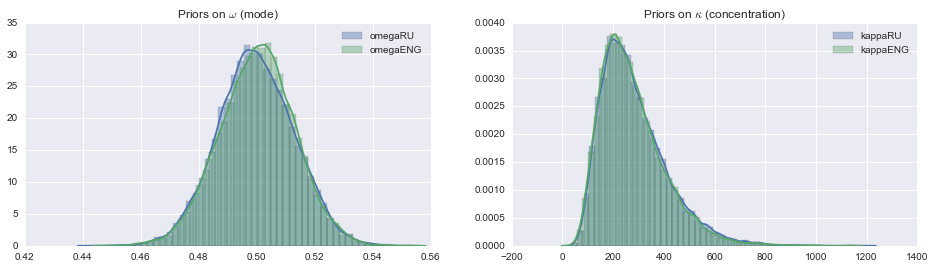

In [41]:
fig = plt.figure(figsize=(16, 4))
ax1 = plt.subplot2grid((1,2), (0,0))
plt.title('Priors on $\omega$ (mode)')
sns.distplot(trace[10000:].get_values('w1'), label='omegaRU');
sns.distplot(trace[10000:].get_values('w2'), label='omegaENG');
plt.legend();
ax2 = plt.subplot2grid((1,2), (0,1))
plt.title('Priors on $\kappa$ (concentration)')
sns.distplot(trace[10000:].get_values('k1'), label='kappaRU');
sns.distplot(trace[10000:].get_values('k2'), label='kappaENG');
plt.legend();

I will package the model into a function, because later on we will have to run it repeatedly.
data1 will be the data coming from Russian sample, and data2 - from American. Here I use adaptive Metropolis-Hastings sampler.

In [44]:
def TrainHierarchicalModel(data1, data2, s_idx, njobs=2, s=0.01, r=0.01, nsamp=10000):
    with pymc3.Model() as model:
        # define the group hyperparameters
        k_minus_two1 = pymc3.Gamma('k_minus_two1', alpha=s, beta=r)
        k1 = pymc3.Deterministic('k1', k_minus_two1 + 2)
        w1 = pymc3.Beta('w1', alpha=1, beta=1)
        k_minus_two2 = pymc3.Gamma('k_minus_two2', alpha=s, beta=r)
        k2 = pymc3.Deterministic('k2', k_minus_two2 + 2)
        w2 = pymc3.Beta('w2', alpha=1, beta=1)    
        # define the prior for group, want to tie story specific theta to it's group theta
        theta1 = pymc3.Beta('theta1', alpha=(w1 * k_minus_two1) + 1, beta=((1-w1)*k_minus_two1)+1, shape=S)
        theta2 = pymc3.Beta('theta2', alpha=(w2 * k_minus_two2) + 1, beta=((1-w2)*k_minus_two2)+1, shape=S)
        # define the likelihood
        y1 = pymc3.Bernoulli('y1', p=theta1[s_idx], observed=data1)
        y2 = pymc3.Bernoulli('y2', p=theta2[s_idx], observed=data2)
    
        wdiff = pymc3.Deterministic('wdiff', w1 - w2)
        thetadiff = pymc3.Deterministic('thetadiff', theta1 - theta2)
        oddsratio = pymc3.Deterministic('oddsratio', (theta2/(1-theta2))/(theta1/(1-theta1)))
        
        step = pymc3.Metropolis() # Instantiate MCMC sampling algorithm
        trace = pymc3.sample(nsamp/njobs, step, njobs=njobs, progressbar=False)
    return model,trace

<h2>Running the model, inspecting the traces</h2>

First, let's run the model on our whole dataset. We will plot the posterior (distribution of parameter values given data) and get some idea about the difference between our groups.

In [46]:
_, trace = TrainHierarchicalModel(data1, data2, s_idx=s_idx, nsamp=nsamp, njobs=njobs)

As a result, the posterior distribution represents what we should believe, given the data, regarding the value of a parameter. This is not distribution of data, but distribution of parameters given the data.
We can inspect trace visually to make sure that chains converge and there are no strange artifacts. I have seen a nice description of a good traceplot: "fat, hairy caterpillar", which doesn't bend (<a href=https://www.crcpress.com/The-BUGS-Book-A-Practical-Introduction-to-Bayesian-Analysis/Lunn-Jackson-Best-Thomas-Spiegelhalter/9781584888499>Lunn et al., 2012</a>; <a href=http://www.ling.uni-potsdam.de/~vasishth/pdfs/SorensenVasishthPsychMethods.pdf>Sorensen and Vasishth, 2015</a>).

There are multiple statistics that can be used for diagnostics, see <a href=http://www.people.fas.harvard.edu/~plam/teaching/methods/convergence/convergence_print.pdf>Patrick Lam's slides</a> for examples. I used Gelman-Rubin statistic to check that we achieved good mixing and convergence (it is around 1 for all parameters).

In [49]:
# Remove semicolon to see the numbers
pymc3.diagnostics.gelman_rubin(trace[5000:]);

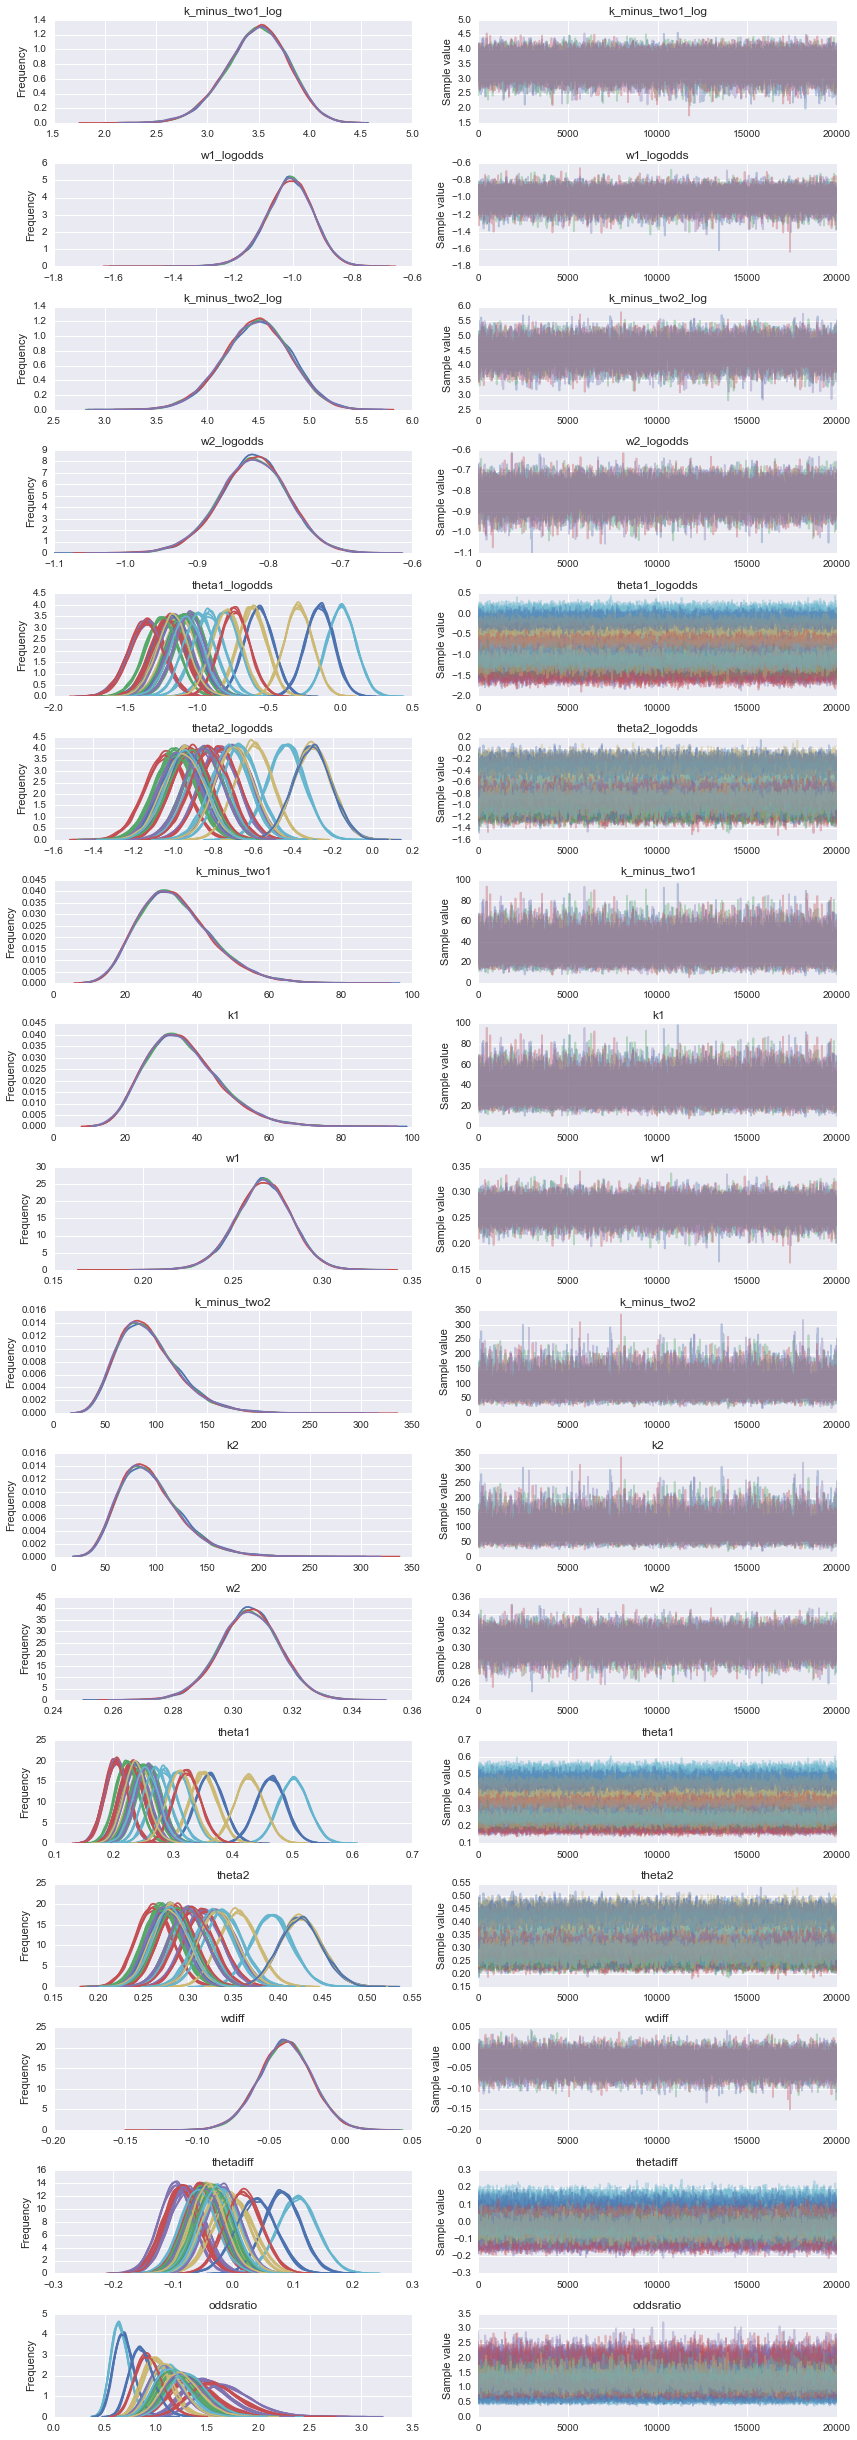

In [50]:
pymc3.traceplot(trace[5000:]);

To get a better idea about the actual results, we take out the traces, and drop first 5000 samples as warm-up. We have a "combine=True" parameter, which just concatenates multiple chains. I also compute highest posterior density intervals (HPD), which define 95% credible values of parameters. These can be used to guide our decisions, for example, if zero value for 'thetadiff' falls into the HPD, then we have to conclude, that zero difference is likely.

I extract the parameter values for $\theta_{g,s}$, $\omega_g$, thetadiff and wdiff. I take the mean over all stories here, to make it easier to display the results. I like to have my histograms with same x-axis scale, so that we can immediately compare them, so I get the range for my histograms from the traces.

In [51]:
# Group RU
theta1_sample = np.mean(trace[5000:].get_values('theta1',combine = True), axis=1)
w1_sample = trace[5000:].get_values('w1',combine = True)
# Group ENG
theta2_sample = np.mean(trace[5000:].get_values('theta2',combine = True), axis=1)
w2_sample = trace[5000:].get_values('w2',combine = True)
# Difference of groups
thetadiff_sample = np.mean(trace[5000:].get_values('thetadiff',combine = True), axis=1)
wdiff_sample = trace[5000:].get_values('wdiff',combine = True)
# HPDs
hpd_theta1_sample = pymc3.stats.hpd(np.array(theta1_sample))
hpd_w1_sample = pymc3.stats.hpd(np.array(w1_sample))
hpd_theta2_sample = pymc3.stats.hpd(np.array(theta2_sample))
hpd_w2_sample = pymc3.stats.hpd(np.array(w2_sample))
hpd_thetadiff = pymc3.stats.hpd(np.array(thetadiff_sample))
hpd_wdiff = pymc3.stats.hpd(np.array(wdiff_sample))
# Histogram range
histrange = list()
histrange.append(np.min(np.concatenate((theta1_sample,theta2_sample))))
histrange.append(np.max(np.concatenate((theta1_sample,theta2_sample))))
histrange_w = list()
histrange_w.append(np.min(np.concatenate((w1_sample,w2_sample))))
histrange_w.append(np.max(np.concatenate((w1_sample,w2_sample))))

<h2>Plot the histograms, inspect group differences</h2>

Here I will plot the histograms of posterior distribution of averaged over stories $\theta_1$ - proportion of extreme judgments of Russian individuals, averaged over stories $\theta_2$ - proportion of extreme judgments of American individuals, and thetadiff - difference in these proportions. I also plot histograms of $\omega_g$, which pretty much represents the group proportion of extreme judgments.

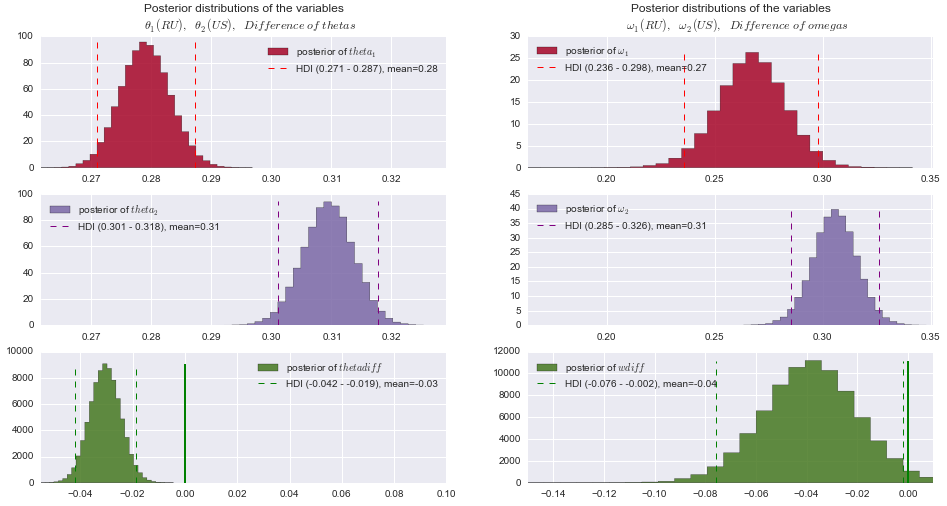

In [62]:
fig = plt.figure(figsize=(16, 8))

# Theta1
ax1 = plt.subplot2grid((3,2), (0,0))
ax1.set_autoscaley_on(True)
bins = plt.hist(theta1_sample, histtype='stepfilled', bins=30, alpha=0.85, label="posterior of $theta_1$", color="#A60628", normed=True)         
plt.vlines(hpd_theta1_sample[0],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'red',label='HDI ({0:.3f} – {1:.3f}), mean={2:.2f}'.format(hpd_theta1_sample[0],hpd_theta1_sample[1],np.mean(theta1_sample)))
plt.vlines(hpd_theta1_sample[1],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'red')
plt.title(r"""Posterior distributions of the variables
    $\theta_1 (RU),\;\theta_2 (US),\;Difference\ of\ thetas$""")
plt.legend(loc="upper right")
plt.xlim(histrange)

# Theta2
ax2 = plt.subplot2grid((3,2), (1,0))
ax2.set_autoscaley_on(True)
bins = plt.hist(theta2_sample, histtype='stepfilled', bins=30, alpha=0.85, label="posterior of $theta_2$", color="#7A68A6", normed=True)
plt.vlines(hpd_theta2_sample[0],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'purple',label='HDI ({0:.3f} – {1:.3f}), mean={2:.2f}'.format(hpd_theta2_sample[0],hpd_theta2_sample[1],np.mean(theta2_sample)))
plt.vlines(hpd_theta2_sample[1],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'purple')
plt.legend(loc="upper left")
plt.xlim(histrange)

# Thetadiff
ax3 = plt.subplot2grid((3,2), (2,0))
bins = plt.hist(thetadiff_sample, histtype='stepfilled', bins=30, alpha=0.85, label=r"posterior of $thetadiff$", color="#467821")
plt.vlines(hpd_thetadiff[0],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'green',label='HDI ({0:.3f} – {1:.3f}), mean={2:.2f}'.format(hpd_thetadiff[0],hpd_thetadiff[1],np.mean(thetadiff_sample)))
plt.vlines(hpd_thetadiff[1],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'green')
plt.vlines(0,0,max(bins[0])+1,linestyle = "-",linewidth = 2,color = 'green')
plt.legend(loc="upper right")
plt.xlim([min(thetadiff_sample),0.1]);

# Omega1
ax4 = plt.subplot2grid((3,2), (0,1))
ax4.set_autoscaley_on(True)
bins = plt.hist(w1_sample, histtype='stepfilled', bins=30, alpha=0.85, label="posterior of $\omega_1$", color="#A60628", normed=True)         
plt.vlines(hpd_w1_sample[0],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'red',label='HDI ({0:.3f} – {1:.3f}), mean={2:.2f}'.format(hpd_w1_sample[0],hpd_w1_sample[1],np.mean(w1_sample)))
plt.vlines(hpd_w1_sample[1],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'red')
plt.title(r"""Posterior distributions of the variables
    $\omega_1 (RU),\;\omega_2 (US),\;Difference\ of\ omegas$""")
plt.legend(loc="upper left")
plt.xlim(histrange_w)

# Omega2
ax5 = plt.subplot2grid((3,2), (1,1))
ax5.set_autoscaley_on(True)
bins = plt.hist(w2_sample, histtype='stepfilled', bins=30, alpha=0.85, label="posterior of $\omega_2$", color="#7A68A6", normed=True)
plt.vlines(hpd_w2_sample[0],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'purple',label='HDI ({0:.3f} – {1:.3f}), mean={2:.2f}'.format(hpd_w2_sample[0],hpd_w2_sample[1],np.mean(w2_sample)))
plt.vlines(hpd_w2_sample[1],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'purple')
plt.legend(loc="upper left")
plt.xlim(histrange_w)

# Omegadiff
ax6 = plt.subplot2grid((3,2), (2,1))
bins = plt.hist(wdiff_sample, histtype='stepfilled', bins=30, alpha=0.85, label=r"posterior of $wdiff$", color="#467821")
plt.vlines(hpd_wdiff[0],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'green',label='HDI ({0:.3f} – {1:.3f}), mean={2:.2f}'.format(hpd_wdiff[0],hpd_wdiff[1],np.mean(wdiff_sample)))
plt.vlines(hpd_wdiff[1],0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'green')
plt.vlines(0,0,max(bins[0])+1,linestyle = "-",linewidth = 2,color = 'green')
plt.legend(loc="upper left")
plt.xlim([min(wdiff_sample),0.01]);

Here we are, we can already see that thetas, averaged over stories, are clearly different in two groups. If we look at the left side of the plot, the green histogram shows the difference, and bold green vertical line shows zero, which is far away from HDI. If we look at the omega hyperparameters and the difference of omegas, we also see the difference, and HDI doesn't overlap with zero. Let's see, how many of the samples we took are different from zero.

In [63]:
np.mean(wdiff_sample<0)

0.98123749999999998

Around 98 percent, looks quite different to me. Let's also look at odds ratio, which is loosely an equivalent of effect size and tells us how likely one group compared to other will give extreme answer.

In [64]:
oddsratio = np.mean(trace[5000:].get_values('oddsratio',combine=True),axis=1)

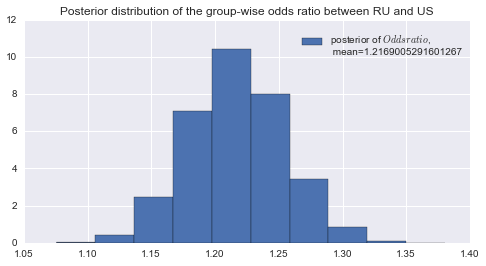

In [72]:
fig = plt.figure(figsize=(8, 4));
plt.hist(oddsratio, label="posterior of $Odds ratio$,\n mean={0}".format(np.mean(oddsratio)), normed=True);  
plt.title(r"""Posterior distribution of the group-wise odds ratio between RU and US""");
plt.legend(loc='upper right');

Let's do the same thing with omegas.

In [74]:
w_oddsratio = (w2_sample/(1-w2_sample))/(w1_sample/(1-w1_sample))

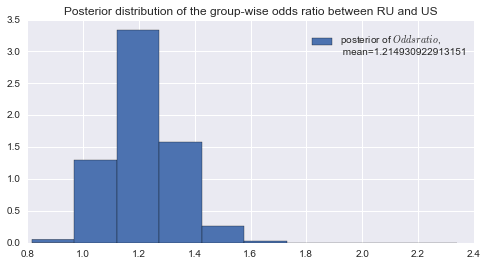

In [75]:
fig = plt.figure(figsize=(8, 4));
plt.hist(w_oddsratio, label="posterior of $Odds ratio$,\n mean={0}".format(np.mean(w_oddsratio)), normed=True);  
plt.title(r"""Posterior distribution of the group-wise odds ratio between RU and US""");
plt.legend(loc='upper right');

From this excercise, we can conclude that there is a difference. We see that the odds that American group will include extreme judgment in their moral dilemmas is about 1.2 times more that in Russian group.
But let's take another step, and do a few checks of our model.

<h2>Posterior predictive check</h2>

In principle, posterior predictive checking goes along the following steps (one small reference: http://www.people.fas.harvard.edu/~plam/teaching/methods/modelcheck/modelcheck_print.pdf):
<ol>
<li>Draw multiple candidate parameter values from posterior.</li>
<li>Simulate datasets using these values.</li>
<li>Choose a statistic, that will reflect some discrepancy between model and real data.</li>
<li>Calculate this statistic over simulated and real data.</li>
<li>Compare and decide, if model requires adjustment.</li>
</ol>

Here I add cross validation to it, so that all of these steps are embedded in following:
<ol>
<li>Split the dataset into training and validation sets.</li>
<li>Simulate datasets from candidate values drawn from model, trained on training set.</li>
<li>Select statistic and calculate it over the simulated data, and real data from validation set.</li>
<li>Check, how does this statistic differ between real and simulated datasets.</li>
</ol>

First, we need to prepare the partitioning, and also decide how many simulations we will do. I decided to have 5 folds for cross validation, and I prepare the indices here, and also to simulate 200 datasets for posterior predictive checks.

In [45]:
nsim = 200 # How many simulated datasets to get
n_folds = 5 # How many folds for cross validation
cv1 = list(KFold(data1.shape[0], n_folds=n_folds))
cv2 = list(KFold(data2.shape[0], n_folds=n_folds))

We will get quite a lot of interesting numbers from this model, and I will initialize the containers for these.

In [46]:
prop_1 = np.empty((S,n_folds),dtype=float) # Proportion of extreme answers for each story in Russian group
prop_2 = np.empty((S,n_folds),dtype=float) # Proportion of extreme answers for each story in American group
oddsratio = np.empty((n_folds),dtype=float) # Odds ratio from real data
prop_yrep1 = np.empty((S,nsim,n_folds),dtype=float) # Proportions for Russian group in simulated datasets
prop_yrep2 = np.empty((S,nsim,n_folds),dtype=float) # Proportions for American group in simulated datasets
oddsratio_yrep = np.empty((nsim,n_folds),dtype=float) # Odds ratio from simulated datasets

Now, there is going to be a lot of code, but let's go through the basic idea.
<ol>
<li> For each fold, I split data into training and testing samples. </li>
<li> I run our model using training dataset. </li>
<li> I draw 200 candidate values from the posterior. </li>
<li> I use them to simulate the datasets (draw random Bernoulli variates). </li>
<li> I calculate average odds ratio over all stories, and proportion of extreme answers for each story. </li>
</ol>

In [49]:
for fold in range(n_folds):
    # Datasets are of unequal size, so we can't use single cv object
    data1_train = data1[cv1[fold][0],:]
    data1_test = data1[cv1[fold][1],:]
    data2_train = data2[cv2[fold][0],:]
    data2_test = data2[cv2[fold][1],:]
    # Store number of left out samples
    n1 = data1_test.shape[0]
    n2 = data2_test.shape[0]
    # Run the chain
    _, trace = TrainHierarchicalModel(data1_train,data2_train,s_idx)
    # 1) Draw 200 candidate values for parameters.
    theta1_rep = trace[nsamp-nsim:].get_values('theta1',combine=True)
    theta2_rep = trace[nsamp-nsim:].get_values('theta2',combine=True)
    # 2) Generate the simulated datasets
    # I have one theta value for each story, so I simulate a dataset for each candidate value of theta
    # I end up with matrix sized: S stories x (n1 or n2) subjects x nsim candidate values
    yrep1 = np.empty((S,n1,nsim),dtype=int)
    yrep2 = np.empty((S,n2,nsim),dtype=int)
    for s in range(S):
        for r in range(nsim):
            yrep1[s,:,r] = sp.bernoulli.rvs(theta1_rep[r,s], size=n1)
            yrep2[s,:,r] = sp.bernoulli.rvs(theta2_rep[r,s], size=n2)        
    # 3) I calculate statistics from simulated data for each fold
    for r in range(nsim):
        prop_yrep1[:,r,fold] = np.array([(yrep1[s,:,r]==1).mean() for s in range(S)])
        prop_yrep2[:,r,fold] = np.array([(yrep2[s,:,r]==1).mean() for s in range(S)])
        oddsratio_yrep[r,fold] = np.mean((prop_yrep2[:,r,fold]/(1-prop_yrep2[:,r,fold]))/(prop_yrep1[:,r,fold]/(1-prop_yrep1[:,r,fold])))
    # 4) Calculate statistics for real values from testing dataset
    prop_1[:,fold] = np.array([(data1_test[:,s]==1).mean() for s in range(S)])
    prop_2[:,fold] = np.array([(data2_test[:,s]==1).mean() for s in range(S)])
    oddsratio[fold] = np.mean((prop_2[:,fold]/(1-prop_2[:,fold]))/(prop_1[:,fold]/(1-prop_1[:,fold])))

Now that we have all the necessary bits calculated, let's look at the difference between real and simulated. First, lets average over cross validation folds.

In [50]:
oddsratio = np.mean(oddsratio)
prop_1 = np.mean(prop_1,1)
prop_2 = np.mean(prop_2,1)
prop_yrep1 = np.mean(prop_yrep1,2)
prop_yrep2 = np.mean(prop_yrep2,2)
oddsratio_yrep = np.mean(oddsratio_yrep,1)

I plot the story-wise proportions from real data for American and Russian groups, and on top of that, I will plot the proportions from simulated datasets. I use scatter type of plot, but maybe for some people line-style plot will be better.

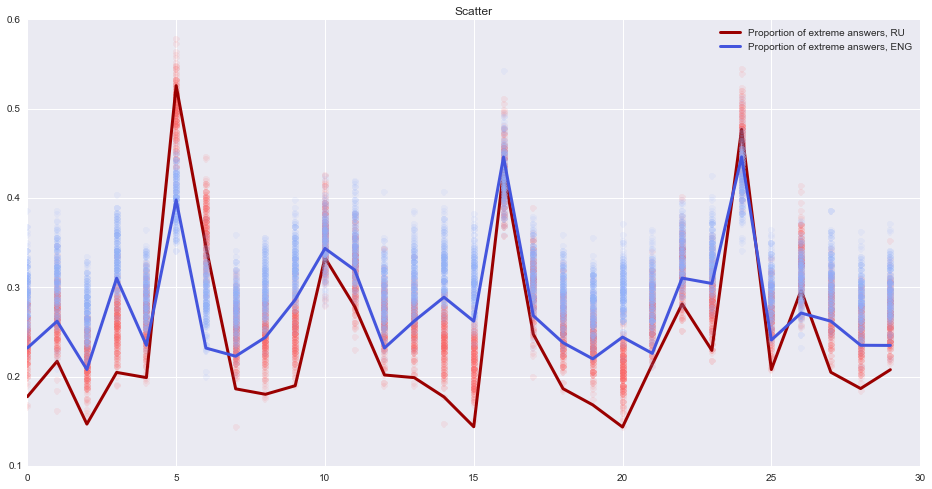

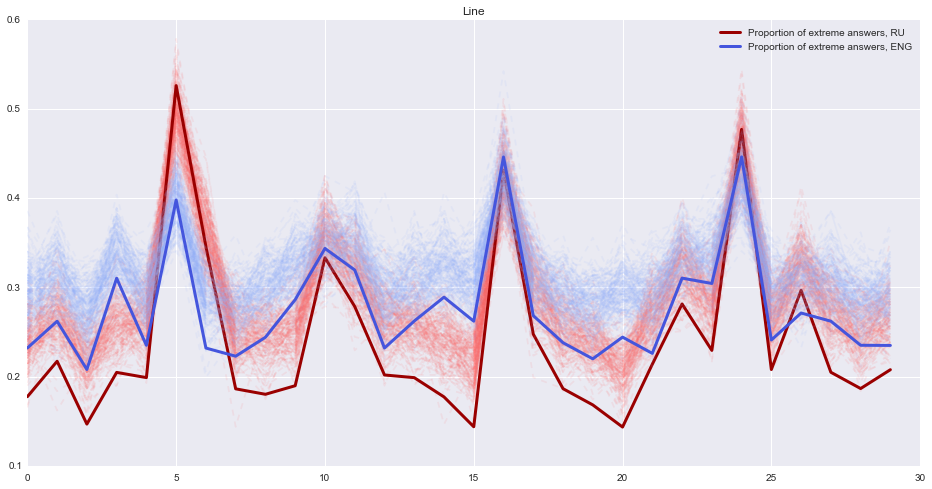

In [55]:
# Circle
fig = plt.figure(figsize=(16, 8));
plt.title('Scatter')
[plt.plot(prop_yrep1[:,r],'#ff6969',alpha=.1,linestyle = '', marker='o') for r in range(nsim)]
plt.plot(prop_1,'#9a0000', alpha=1, lw=3., label='Proportion of extreme answers, RU')
[plt.plot(prop_yrep2[:,r],'#94b2fe',alpha=.1,linestyle = '', marker='o') for r in range(nsim)]
plt.plot(prop_2,'#4455dd', alpha=1, lw=3., label='Proportion of extreme answers, ENG')
plt.legend(loc="upper right");
# Line
fig = plt.figure(figsize=(16, 8));
plt.title('Line')
[plt.plot(prop_yrep1[:,r],'#ff6969',alpha=.1,linestyle = '--') for r in range(nsim)]
plt.plot(prop_1,'#9a0000', alpha=1, lw=3., label='Proportion of extreme answers, RU')
[plt.plot(prop_yrep2[:,r],'#94b2fe',alpha=.1,linestyle = '--') for r in range(nsim)]
plt.plot(prop_2,'#4455dd', alpha=1, lw=3., label='Proportion of extreme answers, ENG')
plt.legend(loc="upper right");

On X axis we have different stories (there were 30). Bold blue line represents the proportion of extreme answers for American sample, and bold red line - proportion of extreme answers for Russian sample. The opaque lines correspond to proportions from simulated data.
Here, according to simulated proportions, it seems that our model overestimates the  proportions slightly, as we can guess from simulations showing a little higher numbers than real data, however, it also seems that the simulated lines follow the real quite well, so no large discrepancy is apparent.

What about odds ratio?

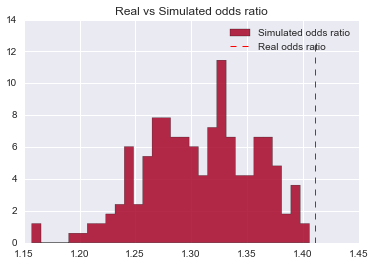

In [57]:
bins = plt.hist(oddsratio_yrep, histtype='stepfilled', bins=30, alpha=0.85, label="Simulated odds ratio", color="#A60628", normed=True);         
plt.vlines(oddsratio,0,max(bins[0])+1,linestyle = "--",linewidth = 1,color = 'red',label='Real odds ratio')
plt.title('Real vs Simulated odds ratio')
plt.legend(loc="upper right");

Finally, the odds ratio is underestimated. All in all, I don't think we have any significant worrysome discrepancy between our model and data. It would be good to also have some other model, to also show some model comparisons, but for now - this is it.